# The job of this notebook is to execute the chained fit in Jinchen's order
### (2-point, Sum-subtracted, 3-point)

In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [2]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [3]:
import pickle

In [4]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [5]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [6]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")


In [7]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and Sum-subtracted samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

<ipython-input-7-5eece56e8865>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-7-5eece56e8865>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
<ipython-input-7-5eece56e8865>:17: RuntimeWarning: invalid value encount

In [8]:
# Create functions to extract the necessary fit-parameters for each function, and to insert priors specific to a function into a more complete parameter list
# Create methods for forming a parameter subset for each of the 3 functions: 2-point, 3-point, sum-subtracted
def param_2pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    return sub_p
      
def param_3pt(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_zs):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    return sub_p

def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

#def param_FHdata(p):
    #sub_p = gv.BufferDict()
    #sub_p['E0'] = p['E0']
    #sub_p['Z0'] = p['Z0']
    #sub_p['Ztilde0'] = p['Ztilde0']
    
    #for k in range(1, num_states_FHdata - 1):
        #sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        #sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        #sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    #sub_p['Z{}'.format(num_states_FHdata - 1)] = p['Z_FHdatamax']
    #sub_p['Ztilde{}'.format(num_states_FHdata - 1)] = p['Ztilde_FHdatamax']
    #sub_p['log(dE{})'.format(num_states_FHdata - 1)] = p['log(FHdata_dEmax)']
    
    #for n in range(num_states_FHdata-1):
        #for m in range(num_states_FHdata-1):
                
            #sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            #sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    #for n in range(num_states_FHdata-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FHdata-1)] = p['gA3_{}FHdatamax'.format(n)]
        #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, n)] = p['gA3_FHdatamax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FHdata-1)] = p['gV4_{}FHdatamax'.format(n)]
        #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, n)] = p['gV4_FHdatamax{}'.format(n)]
        
    #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gA3_FHdatamaxFHdatamax']
    #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gV4_FHdatamaxFHdatamax']
    
    #for n in range(num_states_FHdata):
        #sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        #sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        #sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        #sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    #return sub_p

In [9]:
# Now, create some methods for setting the full posterior, both used and unused variables 
def posterior_2pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = partial_post['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = partial_post['Ztilde{}'.format(k)]
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
        
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post          
              
def posterior_3pt(partial_post, full_prior):
    full_post = gv.BufferDict()
    
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
            
    full_post['Z_FHmax'] = full_prior['Z_FHmax']
    full_post['log(FH_dEmax)'] = full_prior['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = full_prior['gA3_FHmax{}'.format(n)]
        full_post['gA3_{}FHmax'.format(n)] = full_prior['gA3_{}FHmax'.format(n)]
        full_post['gV4_FHmax{}'.format(n)] = full_prior['gV4_FHmax{}'.format(n)]
        full_post['gV4_{}FHmax'.format(n)] = full_prior['gV4_{}FHmax'.format(n)]
        
    full_post['gA3_FHmaxFHmax'] = full_prior['gA3_FHmaxFHmax']
    full_post['gV4_FHmaxFHmax'] = full_prior['gV4_FHmaxFHmax']
              
    return full_post
              
def posterior_FH(partial_post, full_prior):
    full_post['E0'] = partial_post['E0']
    full_post['Z0'] = partial_post['Z0']
    full_post['Ztilde0'] = full_prior['Ztilde0']
    
    for k in range(1, num_zs):
        full_post['log(dE{})'.format(k)] = full_prior['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = full_prior['Z{}'.format(k)]
        full_post['Ztilde{}'.format(k)] = full_prior['Ztilde{}'.format(k)] 
        
    for k in range(1, num_states_FH - 1):
        full_post['log(dE{})'.format(k)] = partial_post['log(dE{})'.format(k)]
        full_post['Z{}'.format(k)] = partial_post['Z{}'.format(k)]
        
    for n in range(num_zs):
        for m in range(num_zs):
            full_post['gA3_{0}{1}'.format(n, m)] = full_prior['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = full_prior['gV4_{0}{1}'.format(n, m)]
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):    
            full_post['gA3_{0}{1}'.format(n, m)] = partial_post['gA3_{0}{1}'.format(n, m)]
            full_post['gV4_{0}{1}'.format(n, m)] = partial_post['gV4_{0}{1}'.format(n, m)]
                        
    full_post['Z_FHmax'] = partial_post['Z{}'.format(num_states_FH - 1)]
    full_post['log(FH_dEmax)'] = partial_post['log(dE{})'.format(num_states_FH - 1)]
              
    for n in range(num_states_FH-1):
        full_post['gA3_FHmax{}'.format(n)] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gA3_{}FHmax'.format(n)] = partial_post['gA3_{0}{1}'.format(n, num_states_FH-1)]
        full_post['gV4_FHmax{}'.format(n)] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, n)]
        full_post['gV4_{}FHmax'.format(n)] = partial_post['gV4_{0}{1}'.format(n, num_states_FH-1)]
        
    full_post['gA3_FHmaxFHmax'] = partial_post['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
    full_post['gV4_FHmaxFHmax'] = partial_post['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)]
      
    return full_post
    

In [10]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [11]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [12]:
num_states_FH = 1 # The number of states that the Feynman-Hellman and sum-subtraction needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [13]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

#def C_FHdata_A3_ss(t, p):
    #return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_A3_ps(t, p):
    #return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))


#def C_FHdata_V4_ss(t, p):  
    #return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_V4_ps(t, p):
    #return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #, axes=[2,0,1]

In [14]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d
    

<ipython-input-14-b534f43d753d>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])


In [15]:
num_zs = 6
num_states_FH = 3 

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

#prior_2ptstep

1


In [16]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.86 [22]    Q = 0.66    logGBF = 483.59

Parameters:
             E0       0.659109 +- 0.00497708             [     0.67 +- 0.02 ]  
             Z0   0.000747066 +- 2.34176e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281508 +- 0.000103288             [   0.003 +- 0.003 ]  
       log(dE1)         -1.06542 +- 0.444697             [  -0.97551 +- 0.7 ]  
             Z1   0.000529446 +- 0.000189051             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00321742 +- 0.00167507             [        0 +- 0.01 ]  
       log(dE2)        -0.734767 +- 0.452652             [  -0.97551 +- 0.7 ]  
             Z2   0.000757611 +- 0.000292612             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00654625 +- 0.00263519             [        0 +- 0.01 ]  
       log(dE3)         -0.81456 +- 0.614238             [  -0.97551 +- 0.7 ]  
             Z3     0.000731681 +- 0.0004258             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.002735

In [17]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [18]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [19]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 46.104

Parameters:
             E0       0.659361 +- 0.00459209             [     0.659109 +- 0.00497708 ]  
             Z0   0.000748322 +- 2.13082e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00282034 +- 9.37097e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.04731 +- 0.392259             [       -1.06542 +- 0.444697 ]  
             Z1   0.000531999 +- 0.000171624             [ 0.000529446 +- 0.000189051 ]  
        Ztilde1     0.00327215 +- 0.00148356             [   0.00321742 +- 0.00167507 ]  
       log(dE2)        -0.731776 +- 0.440911             [      -0.734767 +- 0.452652 ]  
             Z2   0.000762328 +- 0.000289832             [ 0.000757611 +- 0.000292612 ]  
        Ztilde2     0.00656072 +- 0.00262121             [   0.00654625 +- 0.00263519 ]  
       log(dE3)        -0.822442 +- 0.613113             [       -0.81456 +- 0.614238 ]  
            

In [20]:
#current_posterior = open('2pt_FH_3pt_stageFH.obj', 'wb')
#pickle.dump(post_CFH, current_posterior)
#current_posterior.close()

In [21]:
#next_priors = open('2pt_FH_3pt_stageFH.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [22]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)

y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

<ipython-input-22-ddb39a049fb2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-22-ddb39a049fb2>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


In [23]:
fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_CFH, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.83 [130]    Q = 0.92    logGBF = 3332.6

Parameters:
             E0        0.661677 +- 0.00343923             [     0.659361 +- 0.00459209 ]  
             Z0    0.000755996 +- 1.46151e-05             [ 0.000748322 +- 2.13082e-05 ]  
        Ztilde0     0.00285007 +- 6.31454e-05             [  0.00282034 +- 9.37097e-05 ]  
       log(dE1)          -1.05119 +- 0.187671             [       -1.04731 +- 0.392259 ]  
             Z1    0.000500617 +- 9.26283e-05             [ 0.000531999 +- 0.000171624 ]  
        Ztilde1     0.00320461 +- 0.000643066             [   0.00327215 +- 0.00148356 ]  
       log(dE2)         -0.686454 +- 0.248266             [      -0.731776 +- 0.440911 ]  
             Z2    0.000745664 +- 0.000178841             [ 0.000762328 +- 0.000289832 ]  
        Ztilde2      0.00692875 +- 0.00194892             [   0.00656072 +- 0.00262121 ]  
       log(dE3)         -0.890712 +- 0.497459             [      -0.822442 +- 0.613113 ] 

In [24]:
final_posterior = open("Final(3pt)_out.obj", 'wb')
pickle.dump(post_3pt, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-subtracted; E0 = ", post_3pt['E0'], " for 3-point")

E0 =  0.6591(50)  for 2-point; E0 =  0.6594(46)  for sum-subtracted; E0 =  0.6617(34)  for 3-point


In [25]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

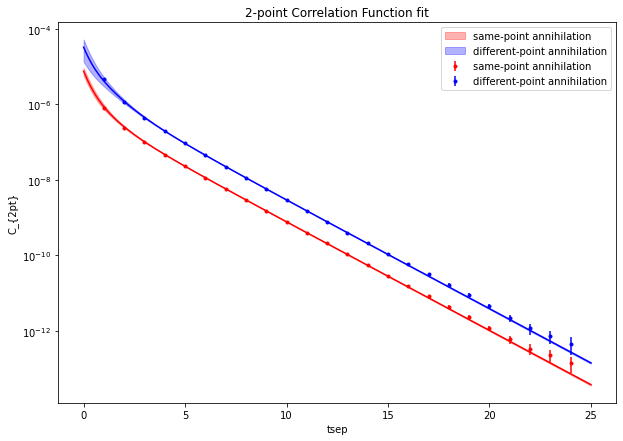

<Figure size 432x288 with 0 Axes>

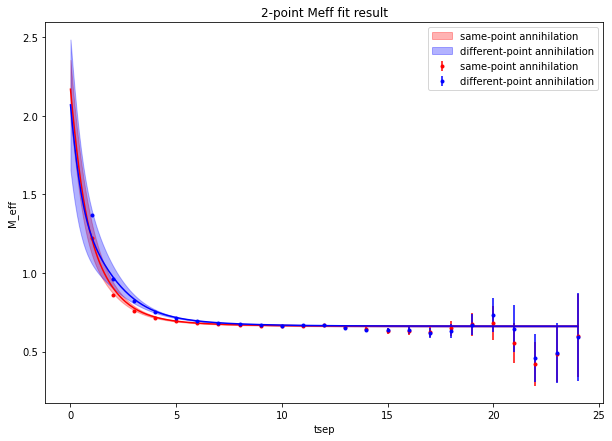

<Figure size 432x288 with 0 Axes>

In [26]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

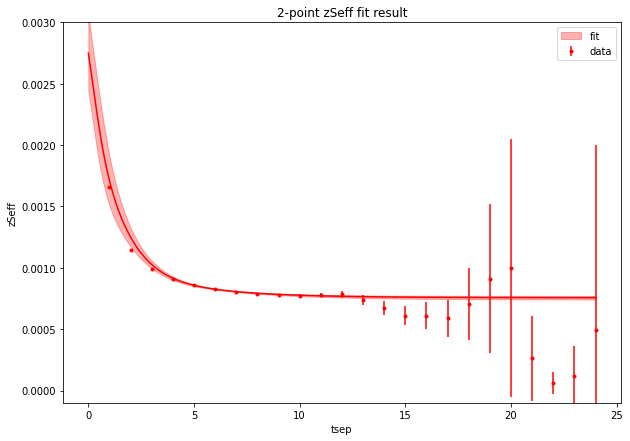

<Figure size 432x288 with 0 Axes>

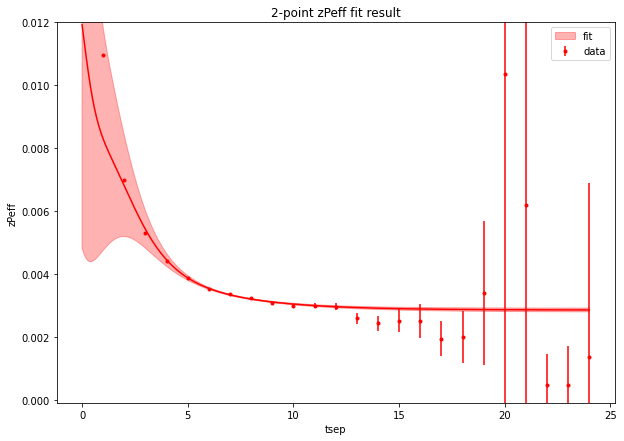

<Figure size 432x288 with 0 Axes>

In [27]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [28]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

<ipython-input-28-d7267048673d>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-28-d7267048673d>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-28-d7267048673d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

<ipython-input-29-ecca070b65b3>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-29-ecca070b65b3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-29-ecca070b65b3>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

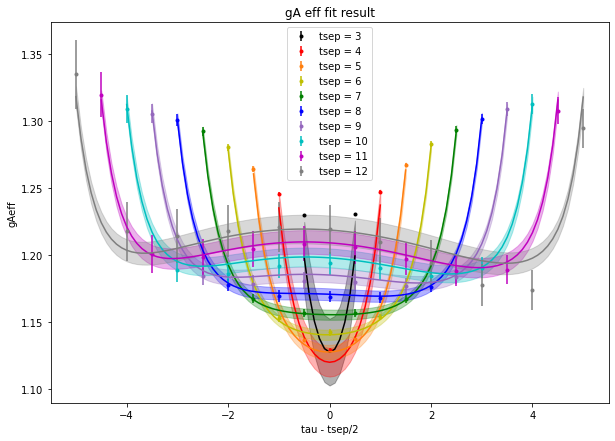

<Figure size 432x288 with 0 Axes>

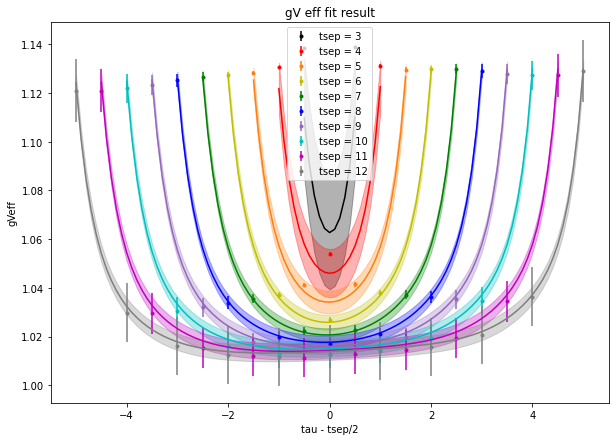

<Figure size 432x288 with 0 Axes>

In [29]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



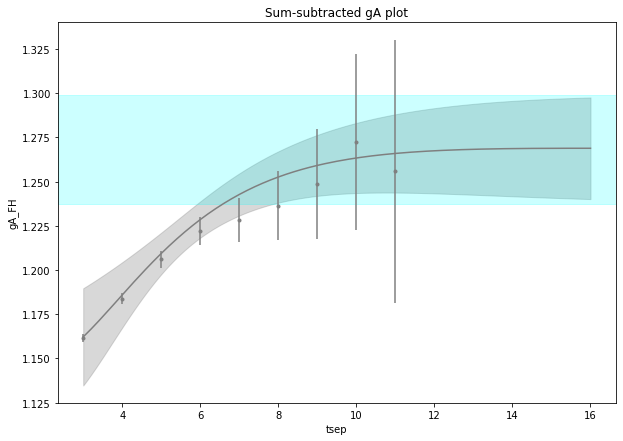

<Figure size 432x288 with 0 Axes>

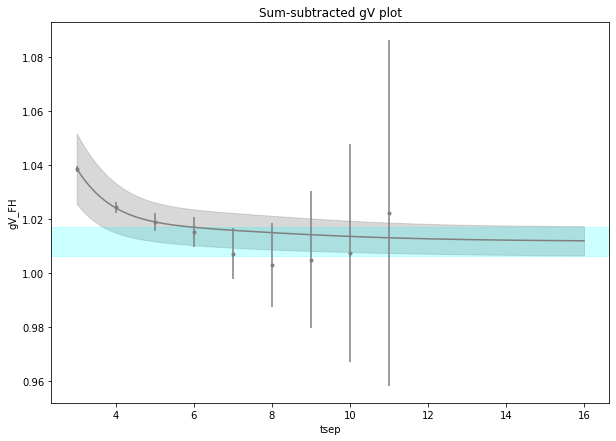

<Figure size 432x288 with 0 Axes>

In [30]:
# And finally, plot the sum-subtracted fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_3pt['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_3pt['gV4_00'], ydat_error=y_CFH_V4_err)



### gA_00 = 1.23 +/- 0.01; gV_00 = 1.019 +/- 0.003

### Now, try again, but with a 3 point with tau 2

In [31]:
num_zs = 4
num_states_FH = 3

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

#prior_2ptstep

1


In [32]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [33]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [34]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [35]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.32 [18]    Q = 1    logGBF = 46.333

Parameters:
             E0       0.661074 +- 0.00274943             [     0.661027 +- 0.00280207 ]  
             Z0   0.000757199 +- 1.01756e-05             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0    0.00286188 +- 4.60965e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.810387 +- 0.133613             [        -0.8113 +- 0.135657 ]  
             Z1   0.000659273 +- 9.38123e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00448196 +- 0.000754108             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.528043 +- 0.437477             [      -0.516866 +- 0.438609 ]  
             Z2    0.000801422 +- 0.00040434             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00587028 +- 0.00306862             [     0.0059393 +- 0.0030705 ]  
       log(dE3)        -0.525482 +- 0.582458             [       -0.526875 +- 0.58489 ]  
            

In [36]:
#current_posterior = open('2pt_FH_3pt_stageFH.obj', 'wb')
#pickle.dump(post_CFH, current_posterior)
#current_posterior.close()

In [37]:
#next_priors = open('2pt_FH_3pt_stageFH.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [38]:
tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

<ipython-input-38-7ea249d6f005>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-38-7ea249d6f005>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


In [39]:


fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_CFH, fcn = C_3pt, debug = True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 1 [90]    Q = 0.4    logGBF = 2353.6

Parameters:
             E0       0.659256 +- 0.00231638             [     0.661074 +- 0.00274943 ]  
             Z0    0.000748614 +- 8.3101e-06             [ 0.000757199 +- 1.01756e-05 ]  
        Ztilde0    0.00281907 +- 3.69447e-05             [  0.00286188 +- 4.60965e-05 ]  
       log(dE1)       -0.907568 +- 0.0804178             [      -0.810387 +- 0.133613 ]  
             Z1    0.00063358 +- 5.05102e-05             [ 0.000659273 +- 9.38123e-05 ]  
        Ztilde1    0.00413435 +- 0.000414519             [  0.00448196 +- 0.000754108 ]  
       log(dE2)       0.0698333 +- 0.0728476             [      -0.528043 +- 0.437477 ]  *
             Z2    0.00149048 +- 0.000177534             [  0.000801422 +- 0.00040434 ]  *
        Ztilde2      0.0113389 +- 0.00125738             [   0.00587028 +- 0.00306862 ]  *
       log(dE3)        -0.300188 +- 0.431431             [      -0.525482 +- 0.582458 ]  
          

In [40]:
final_posterior = open("Final(3pt)_tau2_out.obj", 'wb')
pickle.dump(post_3pt_tau2, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-subtracted; E0 = ", post_3pt_tau2['E0'], " for 3-point")

E0 =  0.6610(28)  for 2-point; E0 =  0.6611(27)  for sum-subtracted; E0 =  0.6593(23)  for 3-point


In [41]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

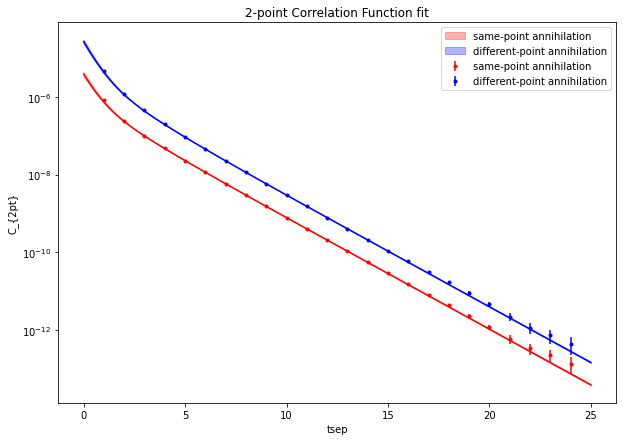

<Figure size 432x288 with 0 Axes>

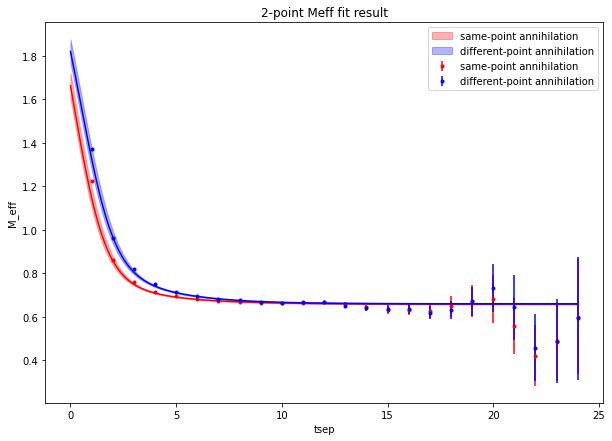

<Figure size 432x288 with 0 Axes>

In [42]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

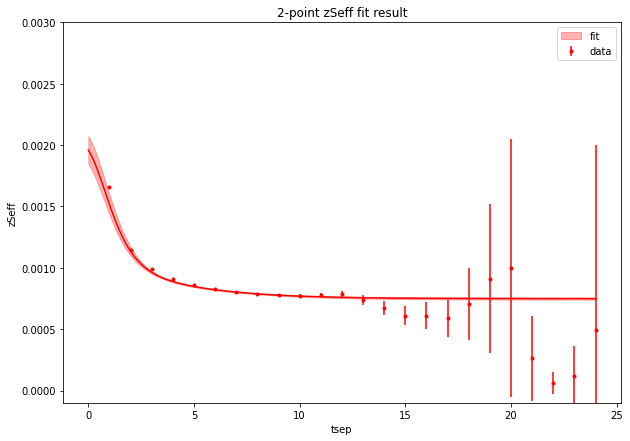

<Figure size 432x288 with 0 Axes>

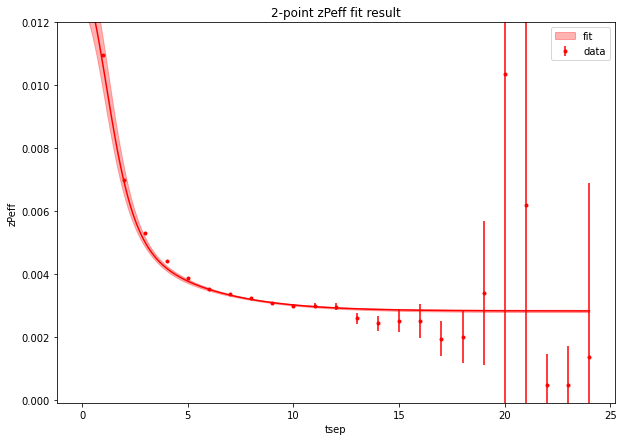

<Figure size 432x288 with 0 Axes>

In [43]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [44]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt_tau2)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

<ipython-input-44-6587168cebeb>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-44-6587168cebeb>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-44-6587168cebeb>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

<ipython-input-45-ecca070b65b3>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-45-ecca070b65b3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-45-ecca070b65b3>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

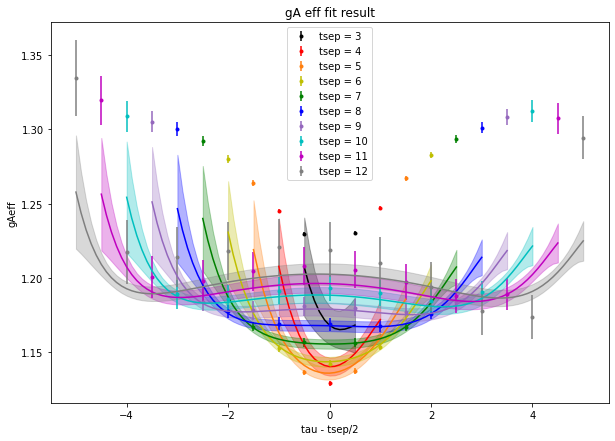

<Figure size 432x288 with 0 Axes>

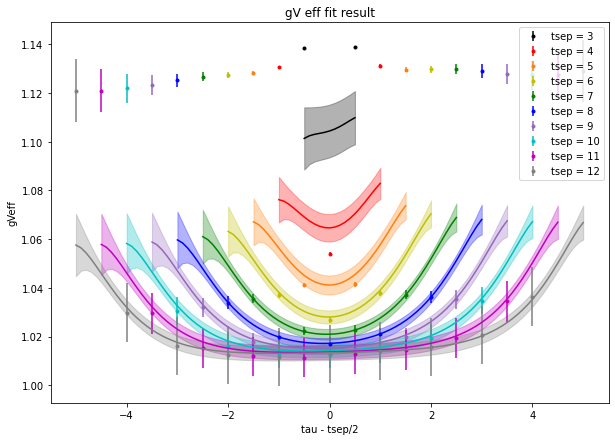

<Figure size 432x288 with 0 Axes>

In [45]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



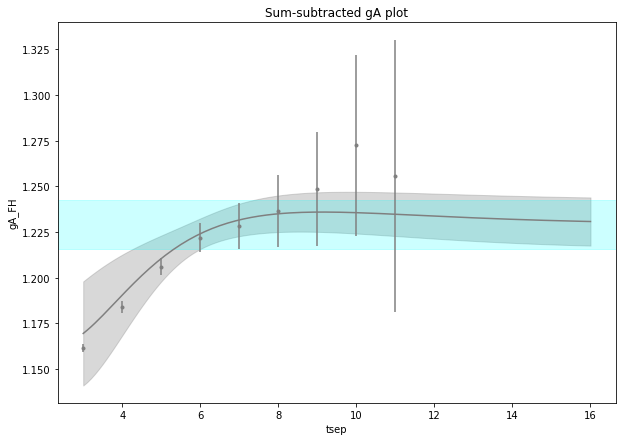

<Figure size 432x288 with 0 Axes>

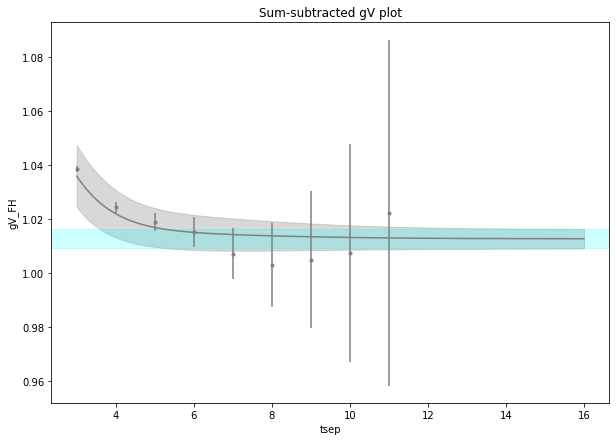

<Figure size 432x288 with 0 Axes>

In [46]:
# And finally, plot the Sum-subtracted fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt_tau2)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt_tau2)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_3pt_tau2['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_3pt_tau2['gV4_00'], ydat_error=y_CFH_V4_err)



### gA3_00 = 1.22815 +- 0.0133987, gV4_00 =1.01296 +- 0.00358532  

## Try adding in the FH fit

In [47]:
num_zs = 7
num_states_FH = 2
#num_states_FHdata = 3

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior_2ptstep["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
prior_2ptstep['Ztilde_FHmax'] = gv.gvar(0, 0.01)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)

#prior_2ptstep

0


In [48]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.9 [22]    Q = 0.59    logGBF = 483.09

Parameters:
             E0       0.659347 +- 0.00482406             [     0.67 +- 0.02 ]  
             Z0   0.000748018 +- 2.26286e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281834 +- 0.000100562             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07435 +- 0.453575             [  -0.97551 +- 0.7 ]  
             Z1   0.000518164 +- 0.000197072             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00318134 +- 0.00168234             [        0 +- 0.01 ]  
       log(dE2)        -0.732238 +- 0.442562             [  -0.97551 +- 0.7 ]  
             Z2   0.000778871 +- 0.000287095             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0064959 +- 0.0026369             [        0 +- 0.01 ]  
       log(dE3)        -0.853576 +- 0.645681             [  -0.97551 +- 0.7 ]  
             Z3   0.000712665 +- 0.000420096             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.0030271

In [49]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [50]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [51]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.39 [18]    Q = 0.99    logGBF = 46.545

Parameters:
             E0       0.659493 +- 0.00468475             [     0.659347 +- 0.00482406 ]  
             Z0   0.000748723 +- 2.21416e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00282116 +- 9.86772e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.06801 +- 0.452498             [       -1.07435 +- 0.453575 ]  
             Z1    0.000515759 +- 0.00019659             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1     0.00319093 +- 0.00168029             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -0.736855 +- 0.44144             [      -0.732238 +- 0.442562 ]  
             Z2   0.000782218 +- 0.000286582             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00646897 +- 0.00262434             [     0.0064959 +- 0.0026369 ]  
       log(dE3)        -0.855432 +- 0.645319             [      -0.853576 +- 0.645681 ]  
         

In [52]:
# Feynman-Hellman fit
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_CFH,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 1.1 [36]    Q = 0.38    logGBF = 144.29

Parameters:
             E0        0.660488 +- 0.00438595             [     0.659493 +- 0.00468475 ]  
             Z0    0.000752768 +- 2.07793e-05             [ 0.000748723 +- 2.21416e-05 ]  
        Ztilde0     0.00284078 +- 9.21318e-05             [  0.00282116 +- 9.86772e-05 ]  
       log(dE1)          -1.00678 +- 0.433305             [       -1.06801 +- 0.452498 ]  
             Z1    0.000535426 +- 0.000192066             [  0.000515759 +- 0.00019659 ]  
        Ztilde1      0.00330857 +- 0.00163253             [   0.00319093 +- 0.00168029 ]  
       log(dE2)         -0.780327 +- 0.437831             [       -0.736855 +- 0.44144 ]  
             Z2    0.000704402 +- 0.000284686             [ 0.000782218 +- 0.000286582 ]  
        Ztilde2       0.0066978 +- 0.00260239             [   0.00646897 +- 0.00262434 ]  
       log(dE3)         -0.926554 +- 0.644318             [      -0.855432 +- 0.645319 ]  


In [53]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)

y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

<ipython-input-53-ddb39a049fb2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-53-ddb39a049fb2>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


In [54]:
fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_FHdata, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.73 [130]    Q = 0.99    logGBF = 3326

Parameters:
             E0        0.661453 +- 0.00345451             [      0.660488 +- 0.00438595 ]  
             Z0    0.000753494 +- 1.53885e-05             [  0.000752768 +- 2.07793e-05 ]  
        Ztilde0     0.00283549 +- 6.73933e-05             [   0.00284078 +- 9.21318e-05 ]  
       log(dE1)           -1.3497 +- 0.258114             [        -1.00678 +- 0.433305 ]  
             Z1    0.000298142 +- 0.000106995             [  0.000535426 +- 0.000192066 ]  *
        Ztilde1     0.00174939 +- 0.000926807             [    0.00330857 +- 0.00163253 ]  
       log(dE2)          -1.28259 +- 0.257493             [       -0.780327 +- 0.437831 ]  *
             Z2    0.000580903 +- 0.000172134             [  0.000704402 +- 0.000284686 ]  
        Ztilde2      0.00402581 +- 0.00180936             [     0.0066978 +- 0.00260239 ]  *
       log(dE3)         -0.818377 +- 0.462697             [       -0.926554 +- 

In [55]:
final_posterior = open("Final(3pt)_withFH_out.obj", 'wb')
pickle.dump(post_3pt, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-sub; E0 = ", post_FHdata['E0'], " for Feynman-Hellman; E0 = ", post_3pt['E0'], " for 3-point")

E0 =  0.6593(48)  for 2-point; E0 =  0.6595(47)  for sum-sub; E0 =  0.6605(44)  for Feynman-Hellman; E0 =  0.6615(35)  for 3-point


In [56]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

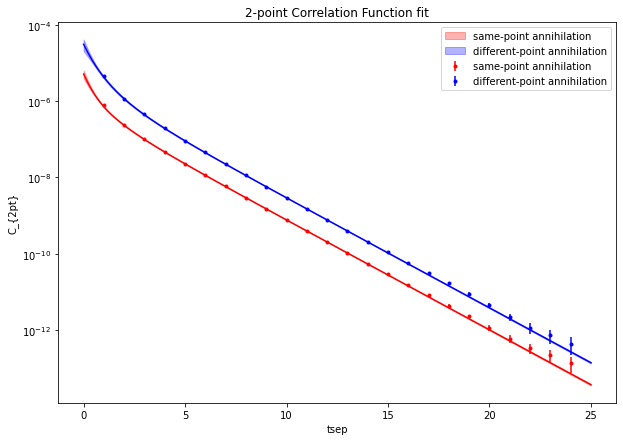

<Figure size 432x288 with 0 Axes>

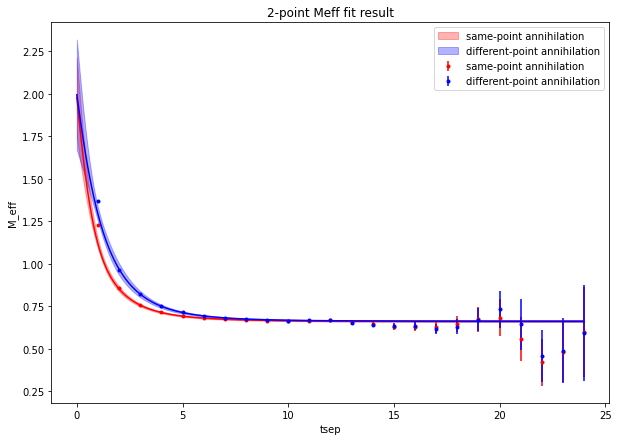

<Figure size 432x288 with 0 Axes>

In [57]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

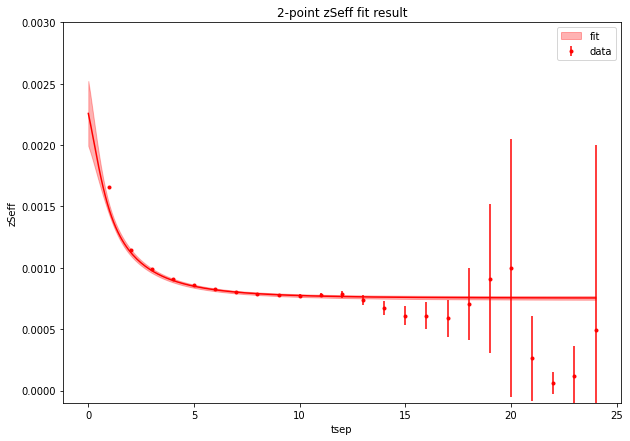

<Figure size 432x288 with 0 Axes>

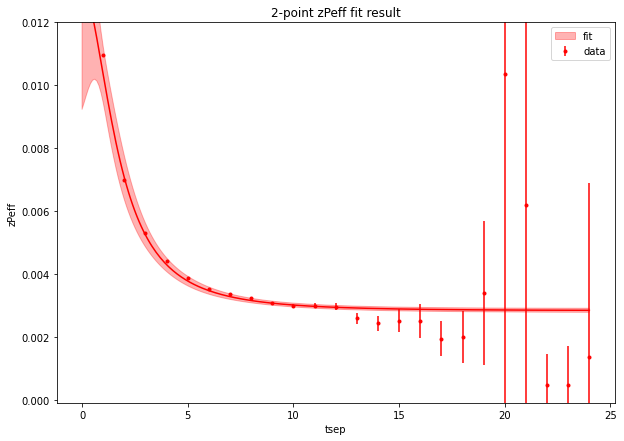

<Figure size 432x288 with 0 Axes>

In [58]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [59]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

<ipython-input-59-d7267048673d>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-59-d7267048673d>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-59-d7267048673d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

<ipython-input-60-ecca070b65b3>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-60-ecca070b65b3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-60-ecca070b65b3>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

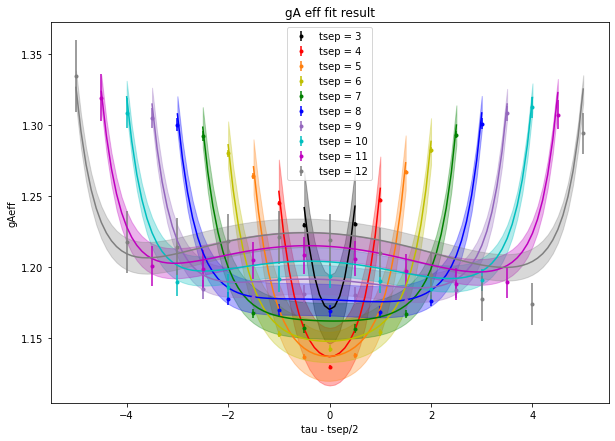

<Figure size 432x288 with 0 Axes>

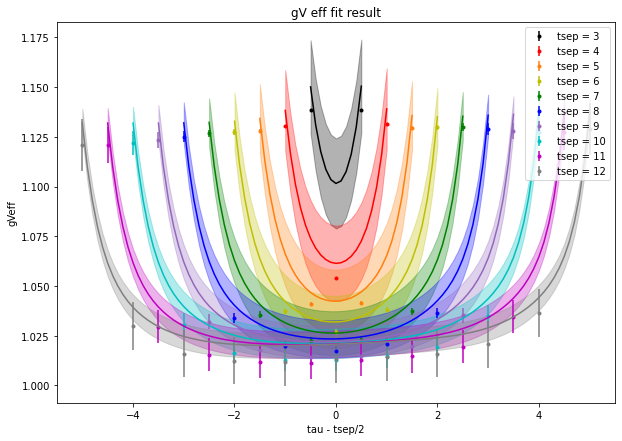

<Figure size 432x288 with 0 Axes>

In [60]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



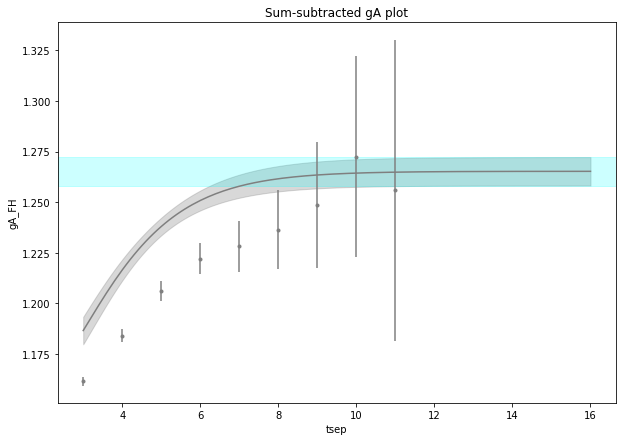

<Figure size 432x288 with 0 Axes>

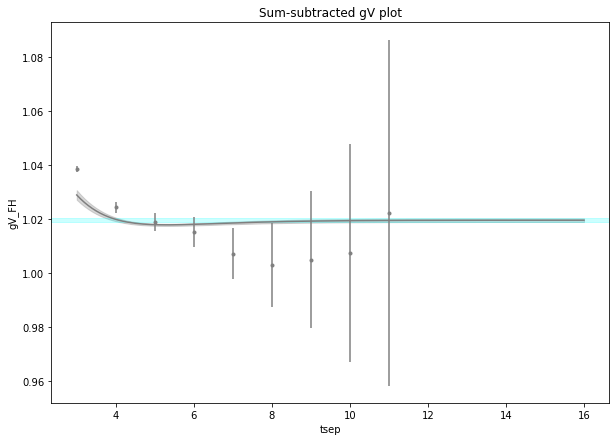

<Figure size 432x288 with 0 Axes>

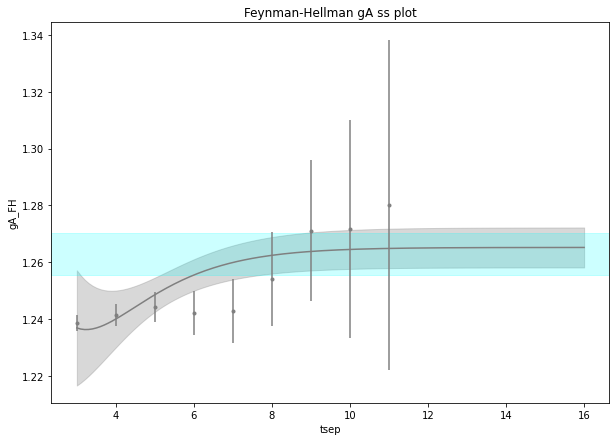

<Figure size 432x288 with 0 Axes>

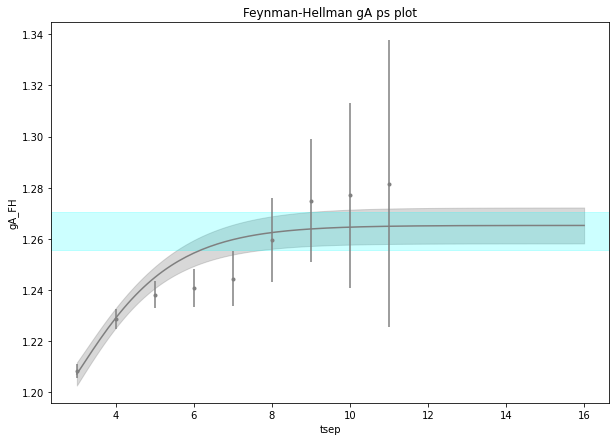

<Figure size 432x288 with 0 Axes>

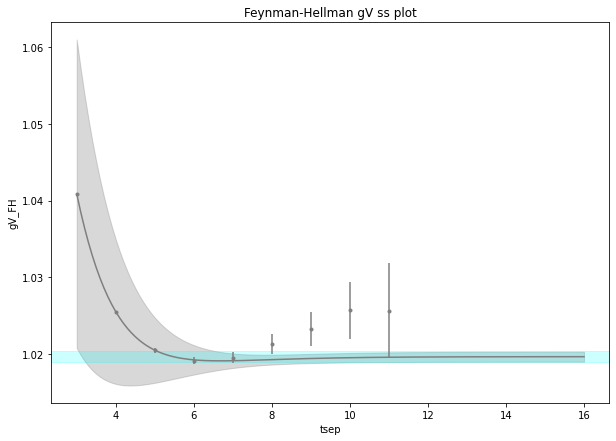

<Figure size 432x288 with 0 Axes>

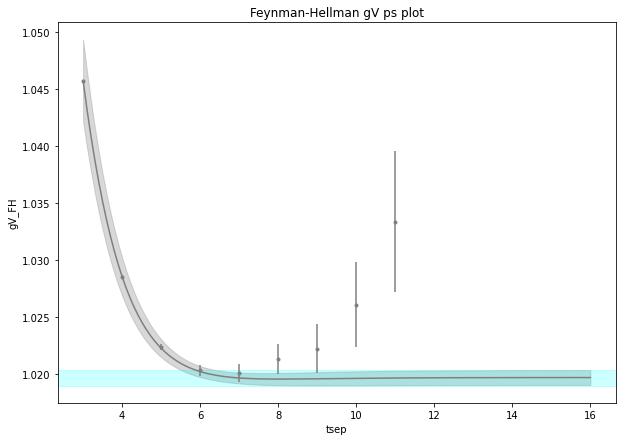

<Figure size 432x288 with 0 Axes>

In [61]:
# And finally, plot the sum-subtracted fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_3pt['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_3pt['gV4_00'], ydat_error=y_CFH_V4_err)

step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)


#CFH_A3_model = C_FH_A3(t_FH_model, post_CFHV4)
#CFH_V4_model = C_FH_V4(t_FH_model, post_CFHV4)
FH_A3_ss_model = C_FHdata_A3_ss(t_FH_model, post_3pt)
FH_A3_ps_model = C_FHdata_A3_ps(t_FH_model, post_3pt)
FH_V4_ss_model = C_FHdata_V4_ss(t_FH_model, post_3pt)
FH_V4_ps_model = C_FHdata_V4_ps(t_FH_model, post_3pt)

FH_A3_ss_model_mean = np.array([FH_A3_ss_model[i].mean for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_upbound = np.array([FH_A3_ss_model[i].mean + FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_lowbound = np.array([FH_A3_ss_model[i].mean - FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ps_model_mean = np.array([FH_A3_ps_model[i].mean for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_upbound = np.array([FH_A3_ps_model[i].mean + FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_lowbound = np.array([FH_A3_ps_model[i].mean - FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_V4_ss_model_mean = np.array([FH_V4_ss_model[i].mean for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_upbound = np.array([FH_V4_ss_model[i].mean + FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_lowbound = np.array([FH_V4_ss_model[i].mean - FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ps_model_mean = np.array([FH_V4_ps_model[i].mean for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_upbound = np.array([FH_V4_ps_model[i].mean + FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_lowbound = np.array([FH_V4_ps_model[i].mean - FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])

# Set up the raw data plotting
x_FHdata = np.array([i for i in tsep_vals[:-1] ])
y_FHdata_A3_ss = np.array([gv_avg_data['FH'][i][0].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ss_err = np.array([gv_avg_data['FH'][i][0].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps = np.array([gv_avg_data['FH'][i][1].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps_err = np.array([gv_avg_data['FH'][i][1].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss = np.array([gv_avg_data['FH'][i][2].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss_err = np.array([gv_avg_data['FH'][i][2].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps = np.array([gv_avg_data['FH'][i][3].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps_err = np.array([gv_avg_data['FH'][i][3].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])

#h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFHV4['gA3_00'], ydat_error=y_CFH_A3_err) 
#h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFHV4['gV4_00'], ydat_error=y_CFH_V4_err)

h5_dm.fit_data_plot("Feynman-Hellman gA ss plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ss, t_FH_model, FH_A3_ss_model_mean, FH_A3_ss_model_upbound, FH_A3_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ss_err) 
h5_dm.fit_data_plot("Feynman-Hellman gA ps plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ps, t_FH_model, FH_A3_ps_model_mean, FH_A3_ps_model_upbound, FH_A3_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ps_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV ss plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ss, t_FH_model, FH_V4_ss_model_mean, FH_V4_ss_model_upbound, FH_V4_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ss_err)
h5_dm.fit_data_plot("Feynman-Hellman gV ps plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ps, t_FH_model, FH_V4_ps_model_mean, FH_V4_ps_model_upbound, FH_V4_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ps_err)

### gA_00 = 1.23 +/- 0.01 ; gV_00 = 1.019 +/- 0.002 


### Now, try again, but with a 3 point with tau 2

In [62]:
num_zs = 4
num_states_FH = 3


# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior_2ptstep['E0'] = gv.gvar(0.67, 0.02)
prior_2ptstep['Z0'] = gv.gvar(0.0008, 0.0003)
prior_2ptstep['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior_2ptstep['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior_2ptstep['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior_2ptstep['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior_2ptstep["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior_2ptstep["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        prior_2ptstep['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior_2ptstep['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior_2ptstep['gA3_00'] = gv.gvar(1.25, 0.15)
prior_2ptstep['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
prior_2ptstep['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
prior_2ptstep['Ztilde_FHmax'] = gv.gvar(0, 0.01)
prior_2ptstep['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior_2ptstep['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior_2ptstep['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior_2ptstep['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior_2ptstep['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)



1


In [63]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=prior_2ptstep,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [64]:
# pickle output params of the 2-point fit, then set the next prior, prior_3pt_A3step
#current_posterior = open('2pt_FH_3pt_stage2pt.obj', 'wb')
#pickle.dump(post_2pt, current_posterior)
#current_posterior.close()

In [65]:
#next_priors = open('2pt_FH_3pt_stage2pt.obj', 'rb')
#prior_CFH = pickle.load(next_priors)
#next_priors.close()

In [66]:
fit_CFH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=post_2pt,fcn=C_FH,debug=True)
print(fit_CFH.format(pstyle='vv'))
post_CFH = fit_CFH.p

Least Square Fit:
  chi2/dof [dof] = 0.31 [18]    Q = 1    logGBF = 44.144

Parameters:
             E0       0.661091 +- 0.00275206             [     0.661027 +- 0.00280207 ]  
             Z0   0.000757305 +- 1.01856e-05             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0     0.00286243 +- 4.6139e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)         -0.80737 +- 0.133738             [        -0.8113 +- 0.135657 ]  
             Z1   0.000661284 +- 9.38685e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00449941 +- 0.000754815             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.523628 +- 0.437582             [      -0.516866 +- 0.438609 ]  
             Z2   0.000801401 +- 0.000404353             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00586376 +- 0.00306865             [     0.0059393 +- 0.0030705 ]  
       log(dE3)          -0.533188 +- 0.5827             [       -0.526875 +- 0.58489 ]  
            

In [67]:
# Feynman-Hellman fit
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_CFH,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 0.74 [36]    Q = 0.88    logGBF = 126.48

Parameters:
             E0        0.661157 +- 0.00264905             [     0.661091 +- 0.00275206 ]  
             Z0    0.000757713 +- 9.69472e-06             [ 0.000757305 +- 1.01856e-05 ]  
        Ztilde0     0.00286329 +- 4.34513e-05             [   0.00286243 +- 4.6139e-05 ]  
       log(dE1)         -0.809536 +- 0.120423             [       -0.80737 +- 0.133738 ]  
             Z1    0.000654784 +- 8.73868e-05             [ 0.000661284 +- 9.38685e-05 ]  
        Ztilde1     0.00448343 +- 0.000690025             [  0.00449941 +- 0.000754815 ]  
       log(dE2)         -0.545765 +- 0.432264             [      -0.523628 +- 0.437582 ]  
             Z2     0.00080496 +- 0.000404076             [ 0.000801401 +- 0.000404353 ]  
        Ztilde2      0.00574785 +- 0.00306136             [   0.00586376 +- 0.00306865 ]  
       log(dE3)           -0.4956 +- 0.570344             [        -0.533188 +- 0.5827 ]  

In [68]:
#next_priors = open('2pt_FH_3pt_stageFH.obj', 'rb')
#prior_3pt = pickle.load(next_priors)
#next_priors.close()

In [69]:
tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

<ipython-input-69-7ea249d6f005>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-69-7ea249d6f005>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


In [70]:


fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_FHdata, fcn = C_3pt, debug = True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 1.1 [90]    Q = 0.24    logGBF = 2351.5

Parameters:
             E0        0.659854 +- 0.00217711             [      0.661157 +- 0.00264905 ]  
             Z0     0.000751453 +- 7.7012e-06             [  0.000757713 +- 9.69472e-06 ]  
        Ztilde0     0.00283127 +- 3.38202e-05             [   0.00286329 +- 4.34513e-05 ]  
       log(dE1)        -0.880197 +- 0.0681413             [       -0.809536 +- 0.120423 ]  
             Z1    0.000634943 +- 4.54954e-05             [  0.000654784 +- 8.73868e-05 ]  
        Ztilde1     0.00425237 +- 0.000353947             [   0.00448343 +- 0.000690025 ]  
       log(dE2)      0.000475151 +- 0.0762327             [       -0.545765 +- 0.432264 ]  *
             Z2     0.00143417 +- 0.000169306             [   0.00080496 +- 0.000404076 ]  *
        Ztilde2       0.0105675 +- 0.00115935             [    0.00574785 +- 0.00306136 ]  *
       log(dE3)         -0.323291 +- 0.422205             [         -0.4956 +- 

In [71]:
final_posterior = open("Final(3pt)_tau2_withFH_out.obj", 'wb')
pickle.dump(post_3pt_tau2, final_posterior)
final_posterior.close()

# Also, print out the result of E0 at each stage
print("E0 = ", post_2pt['E0'], " for 2-point; E0 = ", post_CFH['E0'], " for sum-sub; E0 = ", post_FHdata['E0'], " for Feynman-Hellman; E0 = ", post_3pt_tau2['E0'], " for 3-point")

E0 =  0.6610(28)  for 2-point; E0 =  0.6611(28)  for sum-sub; E0 =  0.6612(26)  for Feynman-Hellman; E0 =  0.6599(22)  for 3-point


In [72]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

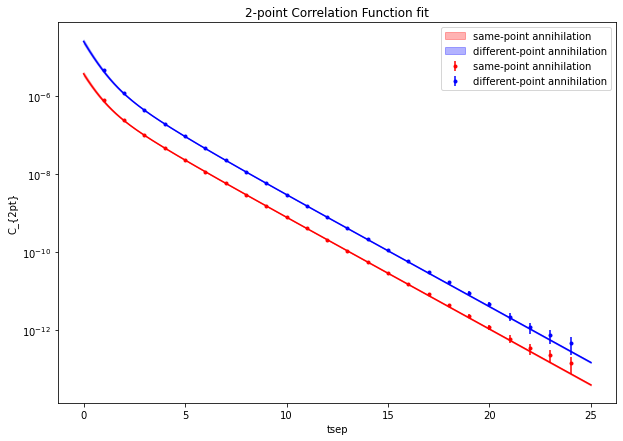

<Figure size 432x288 with 0 Axes>

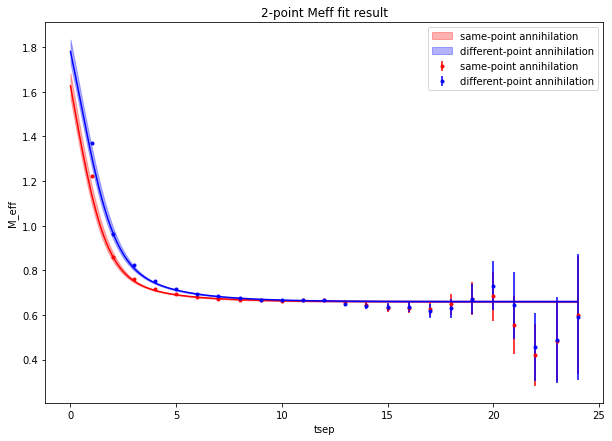

<Figure size 432x288 with 0 Axes>

In [73]:

# Plot the fits


t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

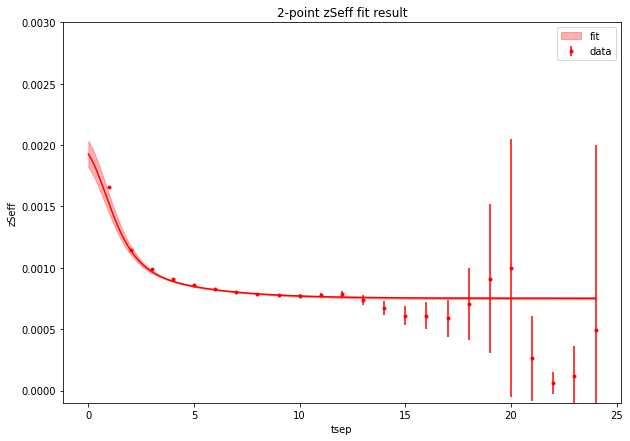

<Figure size 432x288 with 0 Axes>

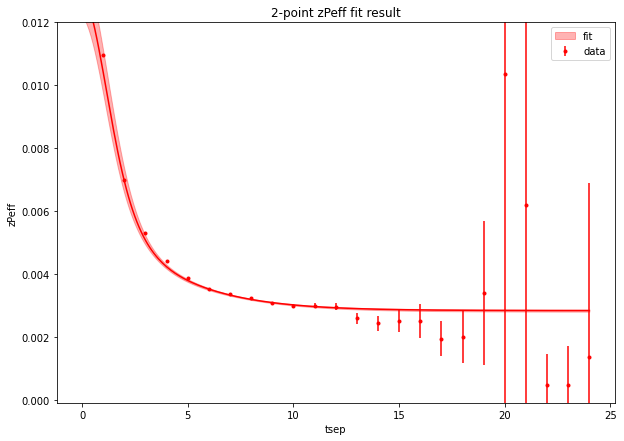

<Figure size 432x288 with 0 Axes>

In [74]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [75]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt_tau2)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

<ipython-input-75-6587168cebeb>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-75-6587168cebeb>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-75-6587168cebeb>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

<ipython-input-76-ecca070b65b3>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-76-ecca070b65b3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
<ipython-input-76-ecca070b65b3>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of li

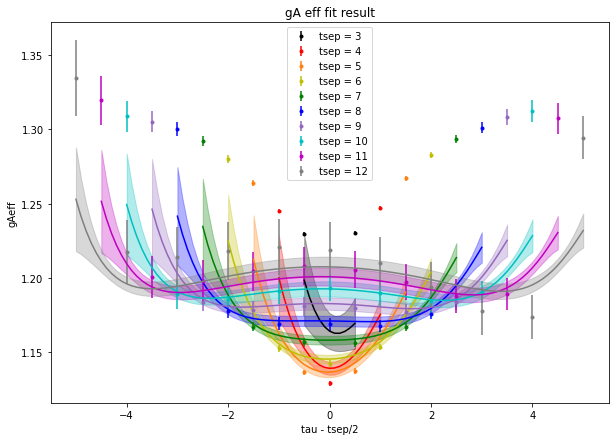

<Figure size 432x288 with 0 Axes>

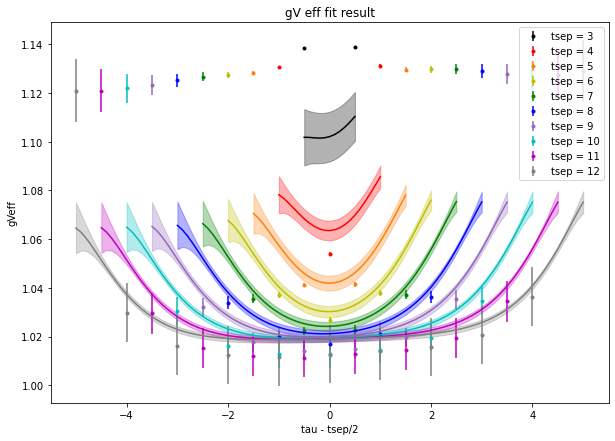

<Figure size 432x288 with 0 Axes>

In [76]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



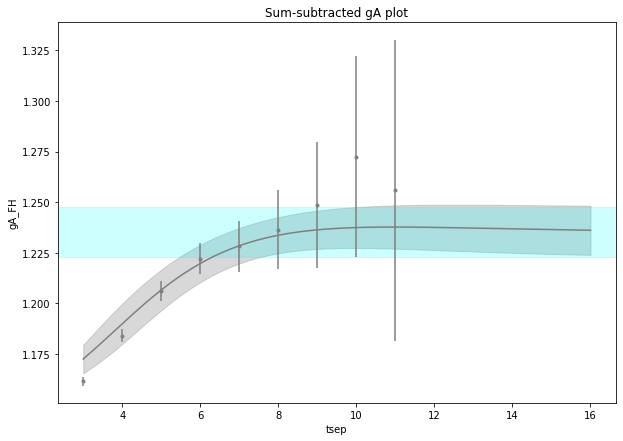

<Figure size 432x288 with 0 Axes>

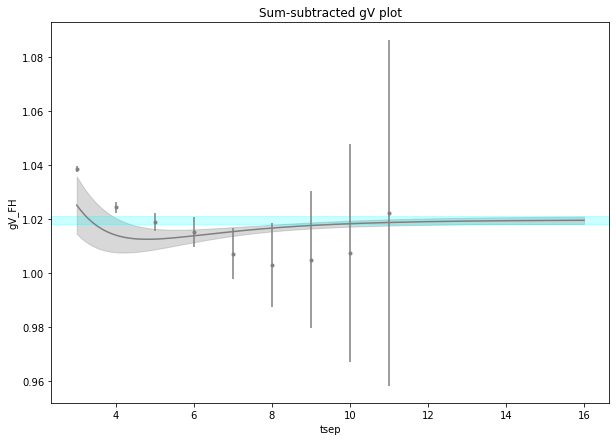

<Figure size 432x288 with 0 Axes>

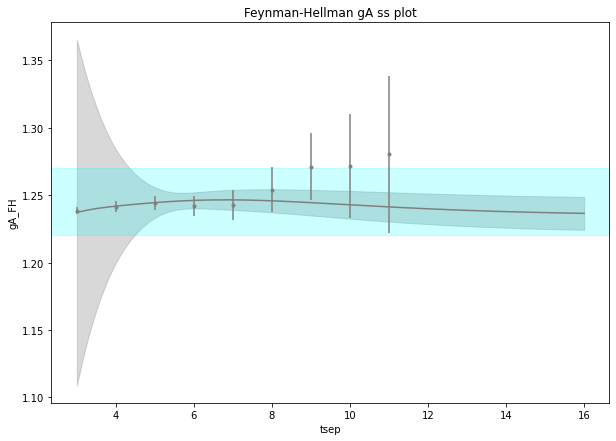

<Figure size 432x288 with 0 Axes>

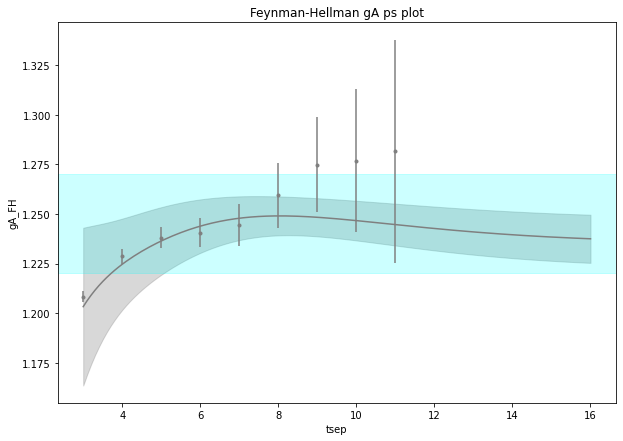

<Figure size 432x288 with 0 Axes>

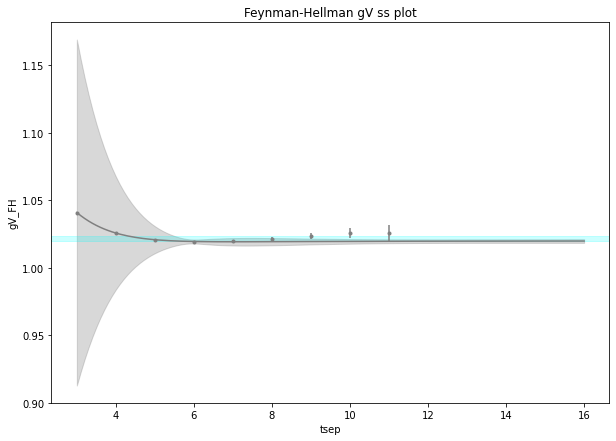

<Figure size 432x288 with 0 Axes>

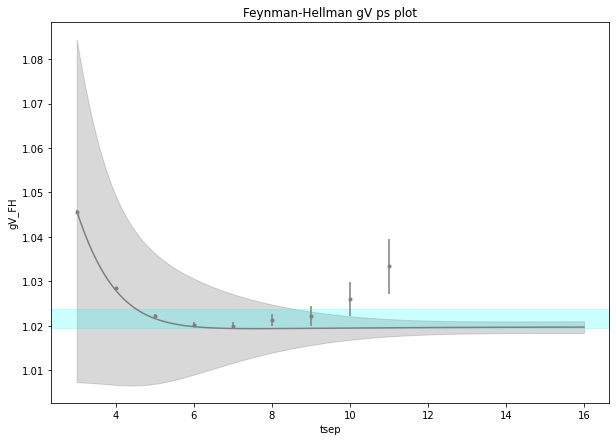

<Figure size 432x288 with 0 Axes>

In [77]:
# And finally, plot the sum-subtracted and sum-subtracted Feynman-Hellman fit functions
step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

CFH_A3_model = C_FH_A3(t_FH_model, post_3pt_tau2)
CFH_V4_model = C_FH_V4(t_FH_model, post_3pt_tau2)

CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

# Set up the raw data plotting
x_CFH = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

h5_dm.fit_data_plot("Sum-subtracted gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_3pt_tau2['gA3_00'], ydat_error=y_CFH_A3_err) 
h5_dm.fit_data_plot("Sum-subtracted gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_3pt_tau2['gV4_00'], ydat_error=y_CFH_V4_err)

step_FH = 10

# Set up the fit plotting
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)


#CFH_A3_model = C_FH_A3(t_FH_model, post_CFHV4)
#CFH_V4_model = C_FH_V4(t_FH_model, post_CFHV4)
FH_A3_ss_model = C_FHdata_A3_ss(t_FH_model, post_3pt_tau2)
FH_A3_ps_model = C_FHdata_A3_ps(t_FH_model, post_3pt_tau2)
FH_V4_ss_model = C_FHdata_V4_ss(t_FH_model, post_3pt_tau2)
FH_V4_ps_model = C_FHdata_V4_ps(t_FH_model, post_3pt_tau2)

FH_A3_ss_model_mean = np.array([FH_A3_ss_model[i].mean for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_upbound = np.array([FH_A3_ss_model[i].mean + FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ss_model_lowbound = np.array([FH_A3_ss_model[i].mean - FH_A3_ss_model[i].sdev for i in range(len(FH_A3_ss_model))])
FH_A3_ps_model_mean = np.array([FH_A3_ps_model[i].mean for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_upbound = np.array([FH_A3_ps_model[i].mean + FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_A3_ps_model_lowbound = np.array([FH_A3_ps_model[i].mean - FH_A3_ps_model[i].sdev for i in range(len(FH_A3_ps_model))])
FH_V4_ss_model_mean = np.array([FH_V4_ss_model[i].mean for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_upbound = np.array([FH_V4_ss_model[i].mean + FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ss_model_lowbound = np.array([FH_V4_ss_model[i].mean - FH_V4_ss_model[i].sdev for i in range(len(FH_V4_ss_model))])
FH_V4_ps_model_mean = np.array([FH_V4_ps_model[i].mean for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_upbound = np.array([FH_V4_ps_model[i].mean + FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])
FH_V4_ps_model_lowbound = np.array([FH_V4_ps_model[i].mean - FH_V4_ps_model[i].sdev for i in range(len(FH_V4_ps_model))])

# Set up the raw data plotting
x_FHdata = np.array([i for i in tsep_vals[:-1] ])
y_FHdata_A3_ss = np.array([gv_avg_data['FH'][i][0].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ss_err = np.array([gv_avg_data['FH'][i][0].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps = np.array([gv_avg_data['FH'][i][1].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_A3_ps_err = np.array([gv_avg_data['FH'][i][1].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss = np.array([gv_avg_data['FH'][i][2].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ss_err = np.array([gv_avg_data['FH'][i][2].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps = np.array([gv_avg_data['FH'][i][3].mean for i in range(np.min(tsep_vals), np.max(tsep_vals))])
y_FHdata_V4_ps_err = np.array([gv_avg_data['FH'][i][3].sdev for i in range(np.min(tsep_vals), np.max(tsep_vals))])

#h5_dm.fit_data_plot("Feynman-Hellman gA plot", "tsep", "gA_FH", x_CFH, y_CFH_A3, t_FH_model, CFH_A3_model_mean, CFH_A3_model_upbound, CFH_A3_model_lowbound, "tab:grey", g00 = post_CFHV4['gA3_00'], ydat_error=y_CFH_A3_err) 
#h5_dm.fit_data_plot("Feynman-Hellman gV plot", "tsep", "gV_FH", x_CFH, y_CFH_V4, t_FH_model, CFH_V4_model_mean, CFH_V4_model_upbound, CFH_V4_model_lowbound, "tab:grey", g00 = post_CFHV4['gV4_00'], ydat_error=y_CFH_V4_err)

h5_dm.fit_data_plot("Feynman-Hellman gA ss plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ss, t_FH_model, FH_A3_ss_model_mean, FH_A3_ss_model_upbound, FH_A3_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ss_err) 
h5_dm.fit_data_plot("Feynman-Hellman gA ps plot", "tsep", "gA_FH", x_FHdata, y_FHdata_A3_ps, t_FH_model, FH_A3_ps_model_mean, FH_A3_ps_model_upbound, FH_A3_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gA3_00'], ydat_error=y_FHdata_A3_ps_err) 
h5_dm.fit_data_plot("Feynman-Hellman gV ss plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ss, t_FH_model, FH_V4_ss_model_mean, FH_V4_ss_model_upbound, FH_V4_ss_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ss_err)
h5_dm.fit_data_plot("Feynman-Hellman gV ps plot", "tsep", "gV_FH", x_FHdata, y_FHdata_V4_ps, t_FH_model, FH_V4_ps_model_mean, FH_V4_ps_model_upbound, FH_V4_ps_model_lowbound, "tab:grey", g00 = post_FHdata['gV4_00'], ydat_error=y_FHdata_V4_ps_err)

#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [78]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [79]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0012, 0.0006)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.01)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            if num_states_FH == 2:
                priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            else:
                priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            for n in range(num_states_FH-1):
                priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
                priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
                priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
            priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [80]:
list_LogGBF_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_FH = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))


In [81]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])

<ipython-input-81-08317326869e>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
<ipython-input-81-08317326869e>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])


In [82]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[0][i][k],fcn=C_2pt,debug=True)
            fit_a1_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[1][i][k],fcn=C_2pt,debug=True)
            fit_a2_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[2][i][k],fcn=C_2pt,debug=True)
                
            fit_a0_FH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a0_2pt.p,fcn=C_FH,debug=True)
            fit_a1_FH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a1_2pt.p,fcn=C_FH,debug=True)
            fit_a2_FH = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['C^FH_combined'][l] for l in range(len(tsep_vals[:-1]))])), prior=fit_a2_2pt.p,fcn=C_FH,debug=True)
            
                
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a0_FH.p,fcn=C_3pt,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a1_FH.p,fcn=C_3pt,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a2_FH.p,fcn=C_3pt,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0_2pt[i][j][k] = fit_a0_2pt.logGBF
            list_LogGBF_a0_FH[i][j][k] = fit_a0_FH.logGBF
            list_LogGBF_a0_3pt[i][j][k] = fit_a0.logGBF
            list_Q_a0_2pt[i][j][k] = fit_a0_2pt.Q
            list_Q_a0_FH[i][j][k] = fit_a0_FH.Q
            list_Q_a0_3pt[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv')) 
            list_LogGBF_a1_2pt[i][j][k] = fit_a1_2pt.logGBF
            list_LogGBF_a1_FH[i][j][k] = fit_a1_FH.logGBF
            list_LogGBF_a1_3pt[i][j][k] = fit_a1.logGBF
            list_Q_a1_2pt[i][j][k] = fit_a1_2pt.Q
            list_Q_a1_FH[i][j][k] = fit_a1_FH.Q
            list_Q_a1_3pt[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a2.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2_2pt[i][j][k] = fit_a2_2pt.logGBF
            list_LogGBF_a2_FH[i][j][k] = fit_a2_FH.logGBF
            list_LogGBF_a2_3pt[i][j][k] = fit_a2.logGBF
            list_Q_a2_2pt[i][j][k] = fit_a2_2pt.Q
            list_Q_a2_FH[i][j][k] = fit_a2_FH.Q
            list_Q_a2_3pt[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 34 [130]    Q = 0    logGBF = 1313.5

Parameters:
             E0         0.68032 +- 0.00101962             [     0.660814 +- 0.00192142 ]  *****
             Z0    0.000809937 +- 2.60515e-06             [ 0.000755492 +- 6.13856e-06 ]  *****
        Ztilde0      0.0031314 +- 1.16919e-05             [  0.00285113 +- 2.87558e-05 ]  *****
       log(dE1)        -0.104963 +- 0.0078521             [      -0.822326 +- 0.057489 ]  *****
             Z1      0.0011081 +- 5.52479e-06             [ 0.000675852 +- 3.48201e-05 ]  *****
        Ztilde1     0.00835906 +- 4.93952e-05             [  0.00457964 +- 0.000248997 ]  *****
       log(dE2)        0.828223 +- 0.00586034             [     -0.132165 +- 0.0422636 ]  *****
             Z2      0.00183915 +- 6.3311e-06             [  0.00132118 +- 1.74106e-05 ]  *****
        Ztilde2       0.013827 +- 6.25025e-05             [  0

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 84 [130]    Q = 0    logGBF = -1956.9

Parameters:
             E0      0.711453 +- 0.000814911             [      0.66064 +- 0.00192967 ]  *****
             Z0   0.000845601 +- 1.88409e-06             [ 0.000755065 +- 6.15182e-06 ]  *****
        Ztilde0    0.00327856 +- 8.80752e-06             [  0.00284932 +- 2.87854e-05 ]  *****
       log(dE1)      -0.315346 +- 0.00504434             [     -0.821562 +- 0.0573835 ]  *****
             Z1   0.000930366 +- 5.82505e-06             [ 0.000677864 +- 3.48684e-05 ]  *****
        Ztilde1      0.00767886 +- 4.451e-05             [  0.00458832 +- 0.000248714 ]  *****
       log(dE2)       0.743688 +- 0.00252642             [     -0.129404 +- 0.0423695 ]  *****
             Z2    0.00183228 +- 5.27903e-06             [   0.00132176 +- 1.7426e-05 ]  *****
        Ztilde2     0.0131913 +- 5.81522e-05             [  0.0098239

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 13 [130]    Q = 9.4e-260    logGBF = 2667.8

Parameters:
             E0        0.684289 +- 0.0010137             [     0.660545 +- 0.00302454 ]  *****
             Z0    0.00083583 +- 2.63217e-06             [ 0.000753827 +- 1.13515e-05 ]  *****
        Ztilde0     0.0032239 +- 1.22946e-05             [  0.00284329 +- 4.86503e-05 ]  *****
       log(dE1)       0.0743631 +- 0.0162588             [     -0.963519 +- 0.0957901 ]  *****
             Z1    0.00098493 +- 1.50317e-05             [ 0.000550131 +- 9.36586e-05 ]  ****
        Ztilde1    0.00829747 +- 0.000125312             [  0.00362226 +- 0.000562644 ]  *****
       log(dE2)        0.404459 +- 0.0556034             [      -0.767077 +- 0.487952 ]  **
             Z2    0.00112672 +- 8.37727e-05             [ 0.000793358 +- 0.000295474 ]  *
        Ztilde2    0.00783316 +- 0.000590424             [   0.00582686

Least Square Fit:
  chi2/dof [dof] = 3.1 [130]    Q = 3.3e-29    logGBF = 3258

Parameters:
             E0       0.660706 +- 0.00180678             [     0.660537 +- 0.00219186 ]  
             Z0   0.000751115 +- 5.97129e-06             [ 0.000754293 +- 7.44644e-06 ]  
        Ztilde0    0.00282083 +- 2.68847e-05             [  0.00284588 +- 3.37759e-05 ]  
       log(dE1)         -1.00036 +- 0.033708             [     -0.835942 +- 0.0628602 ]  **
             Z1   0.000563997 +- 1.48489e-05             [ 0.000671814 +- 3.44422e-05 ]  ***
        Ztilde1    0.00374247 +- 0.000133709             [  0.00450979 +- 0.000269328 ]  **
       log(dE2)       -0.383976 +- 0.0283644             [     -0.157794 +- 0.0527424 ]  ****
             Z2    0.00099165 +- 4.35108e-05             [ 0.000904097 +- 0.000421554 ]  
        Ztilde2    -0.00150888 +- 0.00530677             [   0.00887466 +- 0.00598252 ]  *
       log(dE3)          1.24326 +- 0.033691             [         -3.0441 +- 0.69259 

KeyboardInterrupt: 

In [ ]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [ ]:
# Write to file
F_logGBF_a0_2pt = open("chained2ptFH3pt_logGBF_a0_2pt_data.csv","w")
F_logGBF_a0_FH = open("chained2ptFH3pt_logGBF_a0_FH_data.csv","w")
F_logGBF_a0_3pt = open("chained2ptFH3pt_logGBF_a0_3pt_data.csv","w")
F_Q_a0_2pt = open("chained2ptFH3pt_Q_a0_2pt_data.csv","w")
F_Q_a0_FH = open("chained2ptFH3pt_Q_a0_FH_data.csv","w")
F_Q_a0_3pt = open("chained2ptFH3pt_Q_a0_3pt_data.csv","w")
F_E0_a0 = open("chained2ptFH3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("chained2ptFH3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("chained2ptFH3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("chained2ptFH3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("chained2ptFH3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("chained2ptFH3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1_2pt = open("chained2ptFH3pt_logGBF_a1_2pt_data.csv","w")
F_logGBF_a1_FH = open("chained2ptFH3pt_logGBF_a1_FH_data.csv","w")
F_logGBF_a1_3pt = open("chained2ptFH3pt_logGBF_a1_3pt_data.csv","w")
F_Q_a1_2pt = open("chained2ptFH3pt_Q_a1_2pt_data.csv","w")
F_Q_a1_FH = open("chained2ptFH3pt_Q_a1_FH_data.csv","w")
F_Q_a1_3pt = open("chained2ptFH3pt_Q_a1_3pt_data.csv","w")
F_E0_a1 = open("chained2ptFH3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("chained2ptFH3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("chained2ptFH3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("chained2ptFH3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("chained2ptFH3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("chained2ptFH3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2_2pt = open("chained2ptFH3pt_logGBF_a2_2pt_data.csv","w")
F_logGBF_a2_FH = open("chained2ptFH3pt_logGBF_a2_FH_data.csv","w")
F_logGBF_a2_3pt = open("chained2ptFH3pt_logGBF_a2_3pt_data.csv","w")
F_Q_a2_2pt = open("chained2ptFH3pt_Q_a2_2pt_data.csv","w")
F_Q_a2_FH = open("chained2ptFH3pt_Q_a2_FH_data.csv","w")
F_Q_a2_3pt = open("chained2ptFH3pt_Q_a2_3pt_data.csv","w")
F_E0_a2 = open("chained2ptFH3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("chained2ptFH3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("chained2ptFH3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("chained2ptFH3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("chained2ptFH3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("chained2ptFH3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0_2pt, list_LogGBF_a0_2pt)
dataset_to_CSV(F_logGBF_a0_FH, list_LogGBF_a0_FH)
dataset_to_CSV(F_logGBF_a0_3pt, list_LogGBF_a0_3pt)
dataset_to_CSV(F_Q_a0_2pt, list_Q_a0_2pt)
dataset_to_CSV(F_Q_a0_FH, list_Q_a0_FH)
dataset_to_CSV(F_Q_a0_3pt, list_Q_a0_3pt)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1_2pt, list_LogGBF_a1_2pt)
dataset_to_CSV(F_logGBF_a1_FH, list_LogGBF_a1_FH)
dataset_to_CSV(F_logGBF_a1_3pt, list_LogGBF_a1_3pt)
dataset_to_CSV(F_Q_a1_2pt, list_Q_a1_2pt)
dataset_to_CSV(F_Q_a1_FH, list_Q_a1_FH)
dataset_to_CSV(F_Q_a1_3pt, list_Q_a1_3pt)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2_2pt, list_LogGBF_a2_2pt)
dataset_to_CSV(F_logGBF_a2_FH, list_LogGBF_a2_FH)
dataset_to_CSV(F_logGBF_a2_3pt, list_LogGBF_a2_3pt)
dataset_to_CSV(F_Q_a2_2pt, list_Q_a2_2pt)
dataset_to_CSV(F_Q_a2_FH, list_Q_a2_FH)
dataset_to_CSV(F_Q_a2_3pt, list_Q_a2_3pt)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [ ]:
F_logGBF_a0_2pt_read = open("chained2ptFH3pt_logGBF_a0_2pt_data.csv","r")
F_logGBF_a0_FH_read = open("chained2ptFH3pt_logGBF_a0_FH_data.csv","r")
F_logGBF_a0_3pt_read = open("chained2ptFH3pt_logGBF_a0_3pt_data.csv","r")
F_Q_a0_2pt_read = open("chained2ptFH3pt_Q_a0_2pt_data.csv","r")
F_Q_a0_FH_read = open("chained2ptFH3pt_Q_a0_FH_data.csv","r")
F_Q_a0_3pt_read = open("chained2ptFH3pt_Q_a0_3pt_data.csv","r")
F_E0_a0_read = open("chained2ptFH3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("chained2ptFH3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("chained2ptFH3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("chained2ptFH3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("chained2ptFH3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("chained2ptFH3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_2pt_read = open("chained2ptFH3pt_logGBF_a1_2pt_data.csv","r")
F_logGBF_a1_FH_read = open("chained2ptFH3pt_logGBF_a1_FH_data.csv","r")
F_logGBF_a1_3pt_read = open("chained2ptFH3pt_logGBF_a1_3pt_data.csv","r")
F_Q_a1_2pt_read = open("chained2ptFH3pt_Q_a1_2pt_data.csv","r")
F_Q_a1_FH_read = open("chained2ptFH3pt_Q_a1_FH_data.csv","r")
F_Q_a1_3pt_read = open("chained2ptFH3pt_Q_a1_3pt_data.csv","r")
F_E0_a1_read = open("chained2ptFH3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("chained2ptFH3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("chained2ptFH3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("chained2ptFH3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("chained2ptFH3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("chained2ptFH3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_2pt_read = open("chained2ptFH3pt_logGBF_a2_2pt_data.csv","r")
F_logGBF_a2_FH_read = open("chained2ptFH3pt_logGBF_a2_FH_data.csv","r")
F_logGBF_a2_3pt_read = open("chained2ptFH3pt_logGBF_a2_3pt_data.csv","r")
F_Q_a2_2pt_read = open("chained2ptFH3pt_Q_a2_2pt_data.csv","r")
F_Q_a2_FH_read = open("chained2ptFH3pt_Q_a2_FH_data.csv","r")
F_Q_a2_3pt_read = open("chained2ptFH3pt_Q_a2_3pt_data.csv","r")
F_E0_a2_read = open("chained2ptFH3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("chained2ptFH3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("chained2ptFH3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("chained2ptFH3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("chained2ptFH3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("chained2ptFH3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_2pt_read = CSV_to_dataset(F_logGBF_a0_2pt_read)
list_logGBF_a0_FH_read = CSV_to_dataset(F_logGBF_a0_FH_read)
list_logGBF_a0_3pt_read = CSV_to_dataset(F_logGBF_a0_3pt_read)
list_Q_a0_2pt_read = CSV_to_dataset(F_Q_a0_2pt_read)
list_Q_a0_FH_read = CSV_to_dataset(F_Q_a0_FH_read)
list_Q_a0_3pt_read = CSV_to_dataset(F_Q_a0_3pt_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_2pt_read = CSV_to_dataset(F_logGBF_a1_2pt_read)
list_logGBF_a1_FH_read = CSV_to_dataset(F_logGBF_a1_FH_read)
list_logGBF_a1_3pt_read = CSV_to_dataset(F_logGBF_a1_3pt_read)
list_Q_a1_2pt_read = CSV_to_dataset(F_Q_a1_2pt_read)
list_Q_a1_FH_read = CSV_to_dataset(F_Q_a1_FH_read)
list_Q_a1_3pt_read = CSV_to_dataset(F_Q_a1_3pt_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_2pt_read = CSV_to_dataset(F_logGBF_a2_2pt_read)
list_logGBF_a2_FH_read = CSV_to_dataset(F_logGBF_a2_FH_read)
list_logGBF_a2_3pt_read = CSV_to_dataset(F_logGBF_a2_3pt_read)
list_Q_a2_2pt_read = CSV_to_dataset(F_Q_a2_2pt_read)
list_Q_a2_FH_read = CSV_to_dataset(F_Q_a2_FH_read)
list_Q_a2_3pt_read = CSV_to_dataset(F_Q_a2_3pt_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])





Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [ ]:
# First, add up the logGBFs to get a total value
log_GBF_a0 = list_logGBF_a0_2pt_read + list_logGBF_a0_FH_read + list_logGBF_a0_3pt_read
log_GBF_a1 = list_logGBF_a1_2pt_read + list_logGBF_a1_FH_read + list_logGBF_a1_3pt_read
log_GBF_a2 = list_logGBF_a2_2pt_read + list_logGBF_a2_FH_read + list_logGBF_a2_3pt_read

log_GBF_max_a0 = np.array([np.max(log_GBF_a0[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a1 = np.array([np.max(log_GBF_a1[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a2 = np.array([np.max(log_GBF_a2[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

# First, create a max logGBF array over tau cuts to calculate the Bayes factor
#log_GBF_max_a0_2pt = np.array([np.max(list_logGBF_a0_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_2pt = np.array([np.max(list_logGBF_a1_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_2pt = np.array([np.max(list_logGBF_a2_2pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_2pt = np.array([np.max(np.array([log_GBF_max_a0_2pt[i], log_GBF_max_a1_2pt[i], log_GBF_max_a2_2pt[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_FH = np.array([np.max(list_logGBF_a0_FH_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_FH = np.array([np.max(list_logGBF_a1_FH_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_FH = np.array([np.max(list_logGBF_a2_FH_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_FH = np.array([np.max(np.array([log_GBF_max_a0_FH[i], log_GBF_max_a1_FH[i], log_GBF_max_a2_FH[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_3pt = np.array([np.max(list_logGBF_a0_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_3pt = np.array([np.max(list_logGBF_a1_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_3pt = np.array([np.max(list_logGBF_a2_3pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_3pt = np.array([np.max(np.array([log_GBF_max_a0_3pt[i], log_GBF_max_a1_3pt[i], log_GBF_max_a2_3pt[i]])) for i in range(len(tau_cuts))])

In [ ]:
# Now, calculate the Bayes factor
BF_a0 = np.exp(np.array([ [ [log_GBF_a0[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a1 = np.exp(np.array([ [ [log_GBF_a1[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a2 = np.exp(np.array([ [ [log_GBF_a2[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))


#list_BF_a0_2pt_read = np.exp(np.array([ [ [list_logGBF_a0_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_2pt_read = np.exp(np.array([ [ [list_logGBF_a1_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_2pt_read = np.exp(np.array([ [ [list_logGBF_a2_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_FH_read = np.exp(np.array([ [ [list_logGBF_a0_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_FH_read = np.exp(np.array([ [ [list_logGBF_a1_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_FH_read = np.exp(np.array([ [ [list_logGBF_a2_FH_read[i][j][k] - log_GBF_max_FH[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_3pt_read = np.exp(np.array([ [ [list_logGBF_a0_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_3pt_read = np.exp(np.array([ [ [list_logGBF_a1_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_3pt_read = np.exp(np.array([ [ [list_logGBF_a2_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [ ]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out


In [ ]:
# Now, flatten the arrays
Q_a0_2pt_graph = shape3d_to_2d(list_Q_a0_2pt_read)
Q_a0_FH_graph = shape3d_to_2d(list_Q_a0_FH_read)
Q_a0_3pt_graph = shape3d_to_2d(list_Q_a0_3pt_read)
BF_a0_graph = shape3d_to_2d(BF_a0)
#BF_a0_2pt_graph = shape3d_to_2d(list_BF_a0_2pt_read)
#BF_a0_FH_graph = shape3d_to_2d(list_BF_a0_FH_read)
#BF_a0_3pt_graph = shape3d_to_2d(list_BF_a0_3pt_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_2pt_graph = shape3d_to_2d(list_Q_a1_2pt_read)
Q_a1_FH_graph = shape3d_to_2d(list_Q_a1_FH_read)
Q_a1_3pt_graph = shape3d_to_2d(list_Q_a1_3pt_read)
BF_a1_graph = shape3d_to_2d(BF_a1)
#BF_a1_2pt_graph = shape3d_to_2d(list_BF_a1_2pt_read)
#BF_a1_FH_graph = shape3d_to_2d(list_BF_a1_FH_read)
#BF_a1_3pt_graph = shape3d_to_2d(list_BF_a1_3pt_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_2pt_graph = shape3d_to_2d(list_Q_a2_2pt_read)
Q_a2_FH_graph = shape3d_to_2d(list_Q_a2_FH_read)
Q_a2_3pt_graph = shape3d_to_2d(list_Q_a2_3pt_read)
BF_a2_graph = shape3d_to_2d(BF_a2)
#BF_a2_2pt_graph = shape3d_to_2d(list_BF_a2_2pt_read)
#BF_a2_FH_graph = shape3d_to_2d(list_BF_a2_FH_read)
#BF_a2_3pt_graph = shape3d_to_2d(list_BF_a2_3pt_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

In [ ]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^', '*', 'p'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
ax_labels = np.array(["3 states, 2 for FH", "3 states, 3 for FH", "4 states, 2 for FH", "4 states, 3 for FH", \
                      "5 states, 2 for FH", "5 states, 3 for FH", "6 states, 2 for FH", "6 states, 3 for FH", \
                      "7 states, 2 for FH", "7 states, 3 for FH",])






# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

In [ ]:
# 1/n
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

In [ ]:
# 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, FH")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_zFH_combined)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_2pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_FH_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, FH")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_zFH_combined)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_3pt_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()